In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import signal

### Read this First

#### Remember that `tab` is is useful for autocompletion.

#### Remember that `shift + tab` is useful for rapidly obtaining usage + documentation.

###**3D Camera Geometry**

**In class we covered material for single and multi-camera systems. This notebook will help ground some of these geometric concepts.**

**First, we'll define some of the components helpful for for camera geometry**

In [2]:
def rotatex(t) :
  """ Creates a 3D rotation matrix representing a rotation about the x-axis by t radians """
  return np.array([[1,0,0],[0,np.cos(t),-np.sin(t)],[0,np.sin(t),np.cos(t)]])

def rotatey(t) :
  """ Creates a 3D rotation matrix representing a rotation about the y-axis by t radians """
  return np.array([[np.cos(t),0,np.sin(t)],[0,1,0],[-np.sin(t),0,np.cos(t)]])

def rotatez(t) :
  """ Creates a 3D rotation matrix representing a rotation about the z-axis by t radians """
  return [[np.cos(t),-np.sin(t),0],[np.sin(t),np.cos(t),0],[0,0,1]]

def rotate2D(t) :
  """ Creates a 2D rotation matrix representing a rotation by t radians """
  return [[np.cos(t),-np.sin(t)],[np.sin(t),np.cos(t)]]

def trans(x,y,z) :
  """ Creates a 3D translation vector of shape 3x1 """
  return np.array([[x,y,z]]).T

def pointh(x,y,z) :
  """ Creates a 3D point in homogeneous coordinates """
  return np.array([[x,y,z,1]].T)

def htrans(R,t) :
  """ Creates a 3D homogeneous transformation matrix """
  return np.concatenate((np.concatenate((R,t),axis=1),np.array([[0,0,0,1]])))

**Now, we'll define some components for camera internal geometry**

In [3]:
def Kmatrix(sx,sy,ox,oy) :
  """ Creates the matrix K that represents the calibration matrix """
  return np.array([[sx,0,ox],[0,sy,oy],[0,0,1]])

def Mmatrix(K) :
  """ Creates the matrix M that represents the intrinsic matrix """
  return np.concatenate((K, np.array([[0,0,0]]).T),axis=1)

**Now, write a function that, given a intrinsic matrix M and a extrinsic matrix H, computes the projection matrix P.** 

In [4]:
def Pmatrix(M, H):
  """ Creates a 3x4 projection matrix P that relates world coordinates to pixel coordinates
      Args:
        M: 3x4 matrix representing the intrinsic parameters of the camera
        H: 4x4 matrix representing the extrinsic parameters of the camera
      Return:
        P: 3x4 matrix relating world coordinates to pixel coordinates
  """
  P = M @ H

  return P

**Now, let's make some real world points to project.  Since this is a camera, we'll make the z axis larger than x and y**

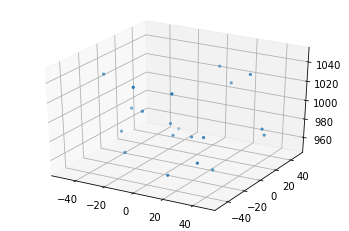

In [5]:
# Make 20 random 3D points stacked horizontally 
pts = np.concatenate((np.random.random([3,20]),np.ones([1,20])),axis=0)
pts[0:2,:] = (pts[0:2,:] - 0.5) * 100
pts[2,:] = (pts[2,:] - 0.5) * 100 + 1000

# Plot these points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(pts[0],pts[1],zs=pts[2],s=5)


**Create an K matrix with parameters $s_x=s_y=1000$, $o_x=52.2$, $o_y=55.3$. Create a H matrix with identity rotation and a translation $(x, y, z)=(42, 33, 1000)$. Then, using those, create the P matrix and print the resulting matrix.**

In [6]:
K = [ [1000 , 0 , 52.2 ] , [0 , 1000 , 55.3 ] , [0 , 0 , 1 ] ]
K = np.array(K , dtype = np.float)
H = [ [1 , 0 , 0 , 42] , [0 , 1 , 0 , 33] , [0 , 0 , 1 , 1000] , [0 , 0 , 0 , 1] ]
H = np.array(H , dtype = np.float)
P = Pmatrix( Mmatrix(K) , H)
print(P)

[[1.00e+03 0.00e+00 5.22e+01 9.42e+04]
 [0.00e+00 1.00e+03 5.53e+01 8.83e+04]
 [0.00e+00 0.00e+00 1.00e+00 1.00e+03]]


**Transform our real world points pts using this projection matrix and store the resulting pixel coordinates into pix_pts. Remember that the results are in homogeneous coordinates so when we plot it we have to ensure that $w=1$ for hoomogeneous coordinate $(u, v, w)$**

[[82.60147442 71.81108326 71.33753539 92.65928602 54.08832108 88.32795575
  59.55812916 61.2234923  72.41209004 52.15236344 68.73378789 66.85276723
  88.42034208 48.26108196 83.41172343 78.47245524 97.11817156 89.25224432
  96.89020483 78.13744316]
 [48.83576475 70.18076522 47.81064095 47.97021193 69.28804959 66.1980886
  95.49541245 59.61434589 95.82167033 78.41781389 73.76395721 60.3216732
  58.61496323 69.17717444 48.01833454 69.70164207 78.76500237 82.81709482
  81.28960669 93.20193873]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.
   1.          1.        ]]


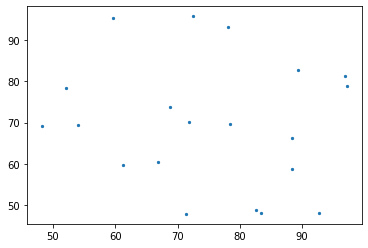

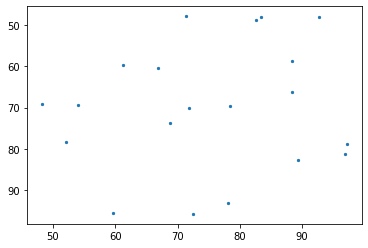

In [7]:
pix_pts = np.zeros((3, 20))
for i in range(pts.shape[1]):
    pix_pts[: , i] = P @ pts[: , i]
    pix_pts[: , i] = pix_pts[: , i] / pix_pts[ 2 , i] 
# Plot these points
print(pix_pts )
fig = plt.figure()
plt.scatter(pix_pts[0], pix_pts[1], s=5)
plt.gca()
plt.show()


fig = plt.figure()
plt.scatter(pix_pts[0], pix_pts[1], s=5)
plt.gca().invert_yaxis()
plt.show()

**Why did I invert the y axis here?**

because in pixel coordinate, origin is on the upper-left corner

**Now we want to compare this with the plot of pts above to see how similar our camera view with the real world. Plot pts as before using scatter, but now adjust viewpoint of the plot to have elevation as $-90$ and azimuth as $-90$.**

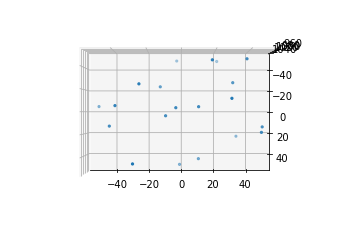

In [8]:
# Plot pts again but with a different viewpoint
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev = -90,    # 仰角
             azim = -90    # 方位角
            )

plt.scatter(pts[0],pts[1],zs=pts[2],s=5)

**Which directions are the x, y, and z axes? (i.e. which is the vertical/horizontal/in or out of plane axis? Which direction is the positive direction for each?)**

x axes:horizontal ,direction: from left to right
y axes:vertical  ,direction: from up to down
z axes: in or out of plane axis, direction : away from viewer(I don't know the proper way to describe it, hope you know what I mean)

**Do your camera points look the same as the real world points? (They should)**

Yes

**Now, change the parameters such that $o_x=0$, recompute the projection matrix, reproject the real world points to the pixel coordinates and plot it as before.**

[[1.00e+03 0.00e+00 0.00e+00 4.20e+04]
 [0.00e+00 1.00e+03 5.53e+01 8.83e+04]
 [0.00e+00 0.00e+00 1.00e+00 1.00e+03]]


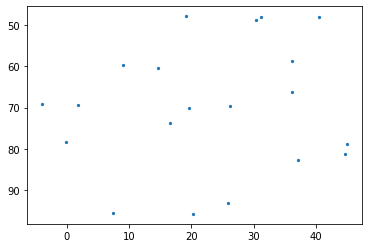

In [9]:
K = [ [1000 , 0 , 0 ] , [0 , 1000 , 55.3 ] , [0 , 0 , 1 ] ]
K = np.array(K , dtype = np.float)
H = [ [1 , 0 , 0 , 42] , [0 , 1 , 0 , 33] , [0 , 0 , 1 , 1000] , [0 , 0 , 0 , 1] ]
H = np.array(H , dtype = np.float)
P = Pmatrix( Mmatrix(K) , H)
print(P)

pix_pts = np.zeros((3, 20))
for i in range(pts.shape[1]):
    pix_pts[: , i] = P @ pts[: , i]
    pix_pts[: , i] = pix_pts[: , i] / pix_pts[ 2 , i] 
# Plot these points
fig = plt.figure()
plt.scatter(pix_pts[0], pix_pts[1], s=5)
plt.gca().invert_yaxis()
plt.show()

**What changed between this and the previous plot you made? What does the parameter $o_x$ represent?**

the position in X direction is changed
ox represent the position of image center in X direction

**Now change $s_y=400$ and do the same thing. Keep $o_x=0$ so you can compare without scrolling too far.**

[[1.00e+03 0.00e+00 0.00e+00 4.20e+04]
 [0.00e+00 4.00e+02 5.53e+01 6.85e+04]
 [0.00e+00 0.00e+00 1.00e+00 1.00e+03]]


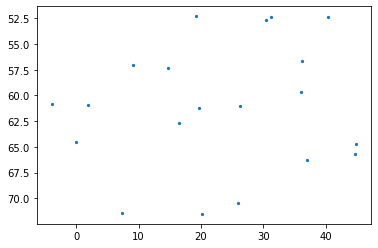

In [10]:
K = [ [1000 , 0 , 0 ] , [0 , 400 , 55.3 ] , [0 , 0 , 1 ] ]
K = np.array(K , dtype = np.float)
H = [ [1 , 0 , 0 , 42] , [0 , 1 , 0 , 33] , [0 , 0 , 1 , 1000] , [0 , 0 , 0 , 1] ]
H = np.array(H , dtype = np.float)
P = Pmatrix( Mmatrix(K) , H)
print(P)

pix_pts = np.zeros((3, 20))
for i in range(pts.shape[1]):
    pix_pts[: , i] = P @ pts[: , i]
    pix_pts[: , i] = pix_pts[: , i] / pix_pts[ 2 , i] 
# Plot these points
fig = plt.figure()
plt.scatter(pix_pts[0], pix_pts[1], s=5)
plt.gca().invert_yaxis()
plt.show()

**What changed between this and the previous plot you made? What does the parameter $s_y$ represent?**

the positions in Y direction are changed
sy represent the scale of camera coordinate position changes in camera pixel coordinate 

**Now let's try and recover the projection matrix. We've already covered this in the Week 6 Python Notebook, so it should be relatively straightforward. Using the real world coordinates pts and the pixel coordinates obtained when we set $s_y=400$ and $o_x=0$ above, create the $A$ matrix in $Ap=0$ that was covered in class to solve for the projection matrix.**

In [11]:
A = np.zeros((2 * 20, 12))

data_num = 20
b = np.zeros((data_num*2, 1))

source = np.array(pts.copy())
source = source.T

target = np.array(pix_pts.copy())
target = target.T

#print(source)
#print(target)
for i in range(data_num):
    base = np.array([source[i][0], source[i][1], source[i][2], 1])
    A[2 * i, 0:4] = base
    A[2 * i + 1, 4:8] = base
    A[2 * i, 8:12] = -target[i][0] * base
    A[2 * i + 1, 8:12] = -target[i][1] * base
print(source.shape)
print(target.shape)

(20, 4)
(20, 3)


**Compute the projection matrix P by solving for $Ap=0$, and print it. Compare it with the projection matrix computed above to confirm that they are identical.**

In [12]:
u, s, vh = np.linalg.svd(A, full_matrices=True)
t = vh[-1, :] / vh[-1, -1]
p = t.reshape(3, 4)
norm = np.linalg.norm(p[2, 0:3])
p = p / norm
print(p)

norm = np.linalg.norm(P[2, 0:3])
P = P / norm
print(P)

[[ 1.00000000e+03  6.34565213e-12  5.70727872e-11  4.20000000e+04]
 [ 1.13375983e-11  4.00000000e+02  5.53000000e+01  6.85000000e+04]
 [-5.21594406e-12 -4.54915867e-13  1.00000000e+00  1.00000000e+03]]
[[1.00e+03 0.00e+00 0.00e+00 4.20e+04]
 [0.00e+00 4.00e+02 5.53e+01 6.85e+04]
 [0.00e+00 0.00e+00 1.00e+00 1.00e+03]]


**Recover the K and R matrices, and then the translation vector t using RQ factorization, and print them to make sure they are consistent with the parameters that you provided to create the projection matrix.**

In [13]:
A = p[: , 0:3].copy()
cx = A[2, 2] / np.sqrt(A[2, 1] ** 2 + A[2, 2] ** 2)
sx = A[2, 1] / np.sqrt(A[2, 1] ** 2 + A[2, 2] ** 2)
Rx = np.array([[1, 0, 0], [0, cx, sx], [0, -sx, cx]])
A = np.matmul(A, Rx)

cy = A[2, 2] / np.sqrt(A[2, 0] ** 2 + A[2, 2] ** 2)
sy = -A[2, 0] / np.sqrt(A[2, 0] ** 2 + A[2, 2] ** 2)
Ry = np.array([[cy, 0, -sy], [0, 1, 0], [sy, 0, cy]])
A = np.matmul(A, Ry)

cz = A[1, 1] / np.sqrt(A[1, 0] ** 2 + A[1, 1] ** 2)
sz = A[1, 0] / np.sqrt(A[1, 0] ** 2 + A[1, 1] ** 2)
Rz = np.array([[cz, sz, 0], [-sz, cz, 0], [0, 0, 1]])
K = np.matmul(A, Rz)
R = np.transpose(Rz) @ np.transpose(Ry) @ np.transpose(Rx)

print(K)
print(R)

[[ 1.00000000e+03  7.55793915e-10 -5.15887127e-09]
 [ 0.00000000e+00  4.00000000e+02  5.53000000e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00 -7.49448262e-13  5.21594406e-12]
 [ 7.49448262e-13  1.00000000e+00  4.54915867e-13]
 [-5.21594406e-12 -4.54915867e-13  1.00000000e+00]]


**Now pick your own parameters for the intrinsic and extrinsic matrices, project pts, and then recover the projection matrix P. Double check that you're able to recover the matrix.**

[[5.50e+02 0.00e+00 3.40e+01 5.71e+04]
 [0.00e+00 3.00e+02 5.53e+01 6.52e+04]
 [0.00e+00 0.00e+00 1.00e+00 1.00e+03]]


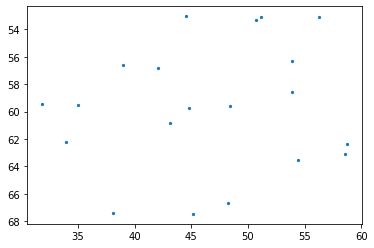

(20, 4)
(20, 3)
[[ 5.50000000e+02 -1.33529020e-10  3.40000000e+01  5.71000000e+04]
 [ 1.55130095e-11  3.00000000e+02  5.53000000e+01  6.52000000e+04]
 [-1.17508363e-12 -2.99042322e-12  1.00000000e+00  1.00000000e+03]]
[[5.50e+02 0.00e+00 3.40e+01 5.71e+04]
 [0.00e+00 3.00e+02 5.53e+01 6.52e+04]
 [0.00e+00 0.00e+00 1.00e+00 1.00e+03]]


In [14]:
K = [ [550 , 0 , 34 ] , [0 , 300 , 55.3 ] , [0 , 0 , 1 ] ]
K = np.array(K , dtype = np.float)
H = [ [1 , 0 , 0 , 42] , [0 , 1 , 0 , 33] , [0 , 0 , 1 , 1000] , [0 , 0 , 0 , 1] ]
H = np.array(H , dtype = np.float)
P = Pmatrix( Mmatrix(K) , H)
print(P)

pix_pts = np.zeros((3, 20))
for i in range(pts.shape[1]):
    pix_pts[: , i] = P @ pts[: , i]
    pix_pts[: , i] = pix_pts[: , i] / pix_pts[ 2 , i] 
# Plot these points
fig = plt.figure()
plt.scatter(pix_pts[0], pix_pts[1], s=5)
plt.gca().invert_yaxis()
plt.show()

A = np.zeros((2 * 20, 12))

data_num = 20
b = np.zeros((data_num*2, 1))

source = np.array(pts.copy())
source = source.T

target = np.array(pix_pts.copy())
target = target.T

#print(source)
#print(target)
for i in range(data_num):
    base = np.array([source[i][0], source[i][1], source[i][2], 1])
    A[2 * i, 0:4] = base
    A[2 * i + 1, 4:8] = base
    A[2 * i, 8:12] = -target[i][0] * base
    A[2 * i + 1, 8:12] = -target[i][1] * base
print(source.shape)
print(target.shape)

u, s, vh = np.linalg.svd(A, full_matrices=True)
t = vh[-1, :] / vh[-1, -1]
p = t.reshape(3, 4)
norm = np.linalg.norm(p[2, 0:3])
p = p / norm
print(p)

norm = np.linalg.norm(P[2, 0:3])
P = P / norm
print(P)

###**Uncalibrated stereo**

**Now that we're more confident with single camera geometry, let's try relate the geometries and the viewpoints of two cameras. The goal of this is to be able to find a relationship between the location of an object in one camera view and the location of the object in the other camera view.**

**Here, let's create 20 random points again** 

In [15]:
# Make 20 random 3D points stacked horizontally 
npoints = 20
pts = np.concatenate((np.random.random([3, npoints]),np.ones([1, npoints])),axis=0)
pts[0:2,:] = (pts[0:2,:] - 0.5) * 100
pts[2,:] = (pts[2,:] - 0.5) * 100 + 1000
colors = plt.cm.rainbow(np.linspace(0, 1, npoints))

**We also plot these points, is a couple of different views that will make more sense that the default view.**

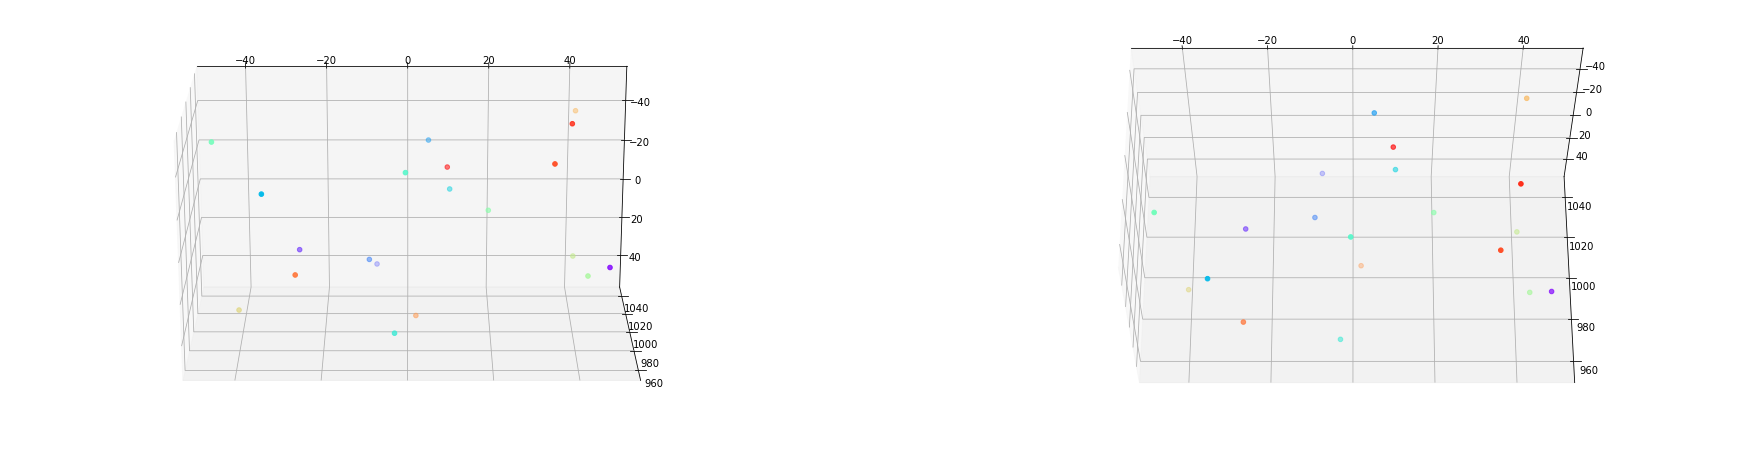

In [16]:
# Plot these points
fig = plt.figure(figsize=(48, 8))
ax = fig.add_subplot(131, projection='3d')
plt.scatter(pts[0],pts[1],zs=pts[2],s=21, c=colors)
ax.view_init(elev=-70, azim=-90)

ax2 = fig.add_subplot(132, projection='3d')
plt.scatter(pts[0],pts[1],zs=pts[2],s=21, c=colors)
ax2.view_init(elev=-30, azim=-90)

**Now we want to simulate two cameras. For camera 1, create a projection matrix with parameters $s_x=s_y=1000$, $o_x=35$, $o_y=55.3$, with a y-axis rotation by -0.3 radians, and a translation vector of $[280, 33, 1000]$.** 

**Project the real world pts above into the view of this camera, and plot these pixel coordinates with the same colours as above corresponding to each point (set c=colors) and remember to invert the y-axis.**

[[ 9.65679696e+02  0.00000000e+00 -2.62083430e+02  3.15000000e+05]
 [ 1.63422674e+01  1.00000000e+03  5.28301078e+01  8.83000000e+04]
 [ 2.95520207e-01  0.00000000e+00  9.55336489e-01  1.00000000e+03]]


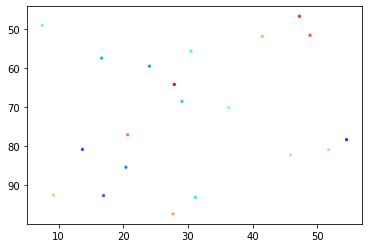

In [17]:
Kl = [ [1000 , 0 , 35 ] , [0 , 1000 , 55.3 ] , [0 , 0 , 1 ] ]
Kl = np.array(Kl , dtype = np.float)
p1 = -0.3
Hl = [ [ np.cos(p1) , 0 , np.sin(p1) , 280] , [0 , 1 , 0 , 33] , [-np.sin(p1) , 0 , np.cos(p1) , 1000] , [0 , 0 , 0 , 1] ]
Hl = np.array(Hl , dtype = np.float)
P1 = Pmatrix( Mmatrix(Kl) , Hl)
print(P1)
pix_pts1 = np.zeros((3, 20))
for i in range(pts.shape[1]):
    pix_pts1[: , i] = P1 @ pts[: , i]
    pix_pts1[: , i] = pix_pts1[: , i] / pix_pts1[ 2 , i]
fig = plt.figure()
plt.scatter(pix_pts1[0], pix_pts1[1], s=5 , c=colors)
plt.gca().invert_yaxis()
plt.show()

**Now simulate camera 2, by creating a projection matrix with parameters $s_x=s_y=1000$, $o_x=35$, $o_y=55.3$, with a y-axis rotation by 0.3 radians, and a translation vector of $[390, 33, 1000]$.** 

**Project the real world pts above into the view of this camera, and plot these pixel coordinates with the same colours as above corresponding to each point (set c=colors) and remember to invert the y-axis.**

[[ 9.44993282e+02  0.00000000e+00  3.28956984e+02  4.25000000e+05]
 [-1.63422674e+01  1.00000000e+03  5.28301078e+01  8.83000000e+04]
 [-2.95520207e-01  0.00000000e+00  9.55336489e-01  1.00000000e+03]]


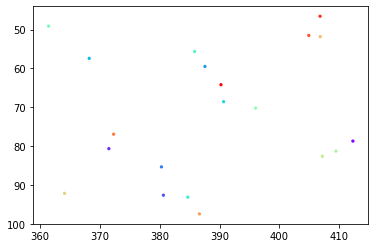

In [18]:
Kr = [ [1000 , 0 , 35 ] , [0 , 1000 , 55.3 ] , [0 , 0 , 1 ] ]
Kr = np.array(Kr , dtype = np.float)
p2 = 0.3
Hr = [ [ np.cos(p2) , 0 , np.sin(p2) , 390] , [0 , 1 , 0 , 33] , [-np.sin(p2) , 0 , np.cos(p2) , 1000] , [0 , 0 , 0 , 1] ]
Hr = np.array(Hr , dtype = np.float)
P2 = Pmatrix( Mmatrix(Kr) , Hr)
print(P2)
pix_pts2 = np.zeros((3, 20))
for i in range(pts.shape[1]):
    pix_pts2[: , i] = P2 @ pts[: , i]
    pix_pts2[: , i] = pix_pts2[: , i] / pix_pts2[ 2 , i]
fig = plt.figure()
plt.scatter(pix_pts2[0], pix_pts2[1], s=5 , c=colors)
plt.gca().invert_yaxis()
plt.show()

**Which camera is the camera on the left? How can you tell?**

the first camera is on the left, according to the radian

**Now we have the pixel coordiantes in both images and we know which pairs of points correspond to each other, we can solve for the fundamental matrix, which relates pixel coordinates from one image to another.**

**Below, fill in the matrix A that you find in slide 46**

In [19]:
A = np.zeros((npoints, 9))
for i in range(npoints):
    pl = pix_pts1[: , i]
    pr = pix_pts2[: , i]
    pl = pl.reshape(3,1)
    pr = pr.reshape(1,3)
    base = np.zeros((9,1),dtype = np.float)
    
    base[0:3] = pl * pr[0,0]
    base[3:6] = pl * pr[0,1]
    base[6:9] = pl * pr[0,2]
    
    base = base.reshape(1,9)
    A[i] = base

**Solve for the fundamental matrix given that $Af=0$, and print out the fundamental matrix F. For reference please see slide 62.**

In [20]:
u, s, vh = np.linalg.svd(A, full_matrices=True)
t = vh[-1, :] / vh[-1, -1]
F = t.reshape(3, 3)
F = F.T
print(F)
for i in range (npoints):
    print(pix_pts1[:, i] @ F @ pix_pts2[:, i])

[[ 2.79823139e-18 -6.48122700e-06  3.58411853e-04]
 [ 4.73523980e-05 -2.59464350e-19  5.60790126e-02]
 [-2.61858761e-03 -7.41621952e-02  1.00000000e+00]]
5.329070518200751e-15
-1.7763568394002505e-15
-2.6645352591003757e-15
0.0
0.0
0.0
8.881784197001252e-16
0.0
1.7763568394002505e-15
0.0
8.881784197001252e-16
4.440892098500626e-15
3.552713678800501e-15
-8.881784197001252e-16
3.1086244689504383e-15
-1.7763568394002505e-15
-1.7763568394002505e-15
4.884981308350689e-15
4.440892098500626e-15
0.0


**Try and recover the essential matrix. We can do this because you already know the calibration matrices $K_r$ and $K_l$. Display the result**

In [21]:
E = Kl.T @ F @ Kr
print(E)

[[ 2.79823139e-12 -6.48122700e+00 -9.31532629e-13]
 [ 4.73523980e+01 -2.59464350e-13  5.77363465e+01]
 [ 7.58941521e-14 -7.43890382e+01 -2.48689958e-14]]


**Given the essential matrix, we can also recover the rotation between the two cameras. Compute $R$, the rotation between the two cameras, using the essential matrix $E$. Display it, and then using rotatey() display the actual rotation between the two cameras (check the extrinsic matrices of the cameras to determine the true rotation between them).**

In [22]:
U,s,VT = np.linalg.svd(E)
S = np.zeros((3,3),dtype = np.float)
S[0,0] = s[0]
S[1,1] = s[1]
S[2,2] = s[2]
W = np.array([ [0,-1.0,0] , [1.0 , 0 , 0] , [0.0 , 0 , 1.0] ] , dtype = np.float)
Z = np.array([ [0,1.0,0] , [-1.0 , 0 , 0] , [0.0 , 0 , 0] ] , dtype = np.float)

R = U @ W.T @ VT
R = R/R[1,1]
print(R )
print(rotatey(-0.6))

[[ 8.25335615e-01  1.81713897e-14 -5.64642473e-01]
 [-1.51791520e-14  1.00000000e+00  1.02747720e-14]
 [ 5.64642473e-01  1.43420040e-17  8.25335615e-01]]
[[ 0.82533561  0.         -0.56464247]
 [ 0.          1.          0.        ]
 [ 0.56464247  0.          0.82533561]]


**Are they the same? They should be.**

**Now try and recover the translation, and display the result.**

In [23]:
T = U @ Z @U.T
print(T)

[[ 0.00000000e+00  8.67972885e-02 -1.39016465e-14]
 [-8.67972885e-02  0.00000000e+00 -9.96225994e-01]
 [ 1.39016465e-14  9.96225994e-01  0.00000000e+00]]


**Chances are, this will be different from the true translation between the cameras. Why is this so?**

The translation is up to scale

**Now let's try and plot the epipolar lines. Write a function that given the fundamental matrix and an image pixel coordinate in either the left or the right image, returns the coefficients of the epipolar line in the other image.**

In [24]:
def findEpipolar(F, pix_l=None, pix_r=None):
    """ Computes the epipolar line coefficients given the fundamental matrix F and either
          the pixel coordinates in the left image (pix_l) or the pixel coordinates in the 
          right image (pix_r)
          Args:
            F: Fundamenal matrix 3x3 that relates pixels in one image to another
            pix_l: Pixel coordinate in the left image (shape [3, 1])
            pix_r: Pixel coordinate in the right image(shape [1, 3])
          Return:
            line_coeff: The coefficients of the epipolar line in the other image
                        If the equation is au + bv + c = 0, the line_coeff = [a, b, c]
    """

    # If the right pixel coordinate is provided, we want to find the coefficients of
    # the line in the left image
    if pix_l is None:
        line_coeff = F @ pix_r.reshape(3,1)
        line_coeff = line_coeff.reshape(1,3)
    # If the left pixel coordinate is provided, we want to find the coefficients of 
    # the line in the right image
    elif pix_r is None:
        line_coeff = pix_l.reshape(1,3) @ F
        line_coeff = line_coeff.reshape(1,3)
    else:
        line_coeff = None
    
    return line_coeff

**Now complete the function below, that given the coefficient of the line and either the $x$ or the $y$ coordinate, finds the other one.**

In [25]:
def findOther(line_coeff, u=None, v=None):
    """ Given the coefficients of au + bv + c = 0 in the form [a, b, c], compute either
      u if v is given, or v if u is given.
      Args:
        line_coeff: [a, b, c] vector of the coefficients of the equation above
        u: The x coordinate of the pixel
        v: The y coordinate of the pixel
      Return:
        The other pixel coordinate, None if nothing else is provided
    """
    #print(line_coeff)
    #print(line_coeff.shape)
    if u is None:
        a = line_coeff[0,0]
        b = line_coeff[0,1]
        c = line_coeff[0,2]
        u = (-1*b*v - c )/a 
      
        return ( u , v)

    elif v is None:
        a = line_coeff[0,0]
        b = line_coeff[0,1]
        c = line_coeff[0,2]
        v = (-1*a*u - c)/b
        return ( u , v)
    
    return None

**Now, using the two functions above, plot the epipolar lines corresponding to the points from the right image onto the left image. Plot the points in the left image in the same plot. Make sure that the colours match, and each point in the left image should have an epipolar line that passes through them.**

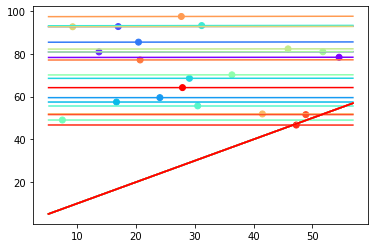

In [26]:
plt.scatter(pix_pts1[0,:], pix_pts1[1,:], c=colors)
s,e = plt.gca().get_xlim()

u = np.linspace(s,e,100)

for i in range(len(pix_pts2.T)):
    coef = findEpipolar(F, pix_r=pix_pts2[:,i])
    v = []
    for j in range(100):
        v.append(findOther(coef, u=u[j]))
    plt.plot(u,np.array(v),c=colors[i])

plt.show()

**Now do the same thing, plotting the epipolar lines corresponding to left image points onto the right image.**

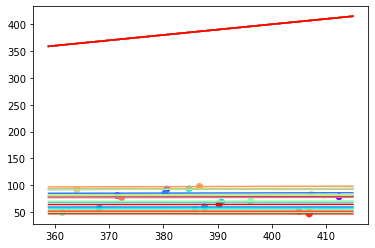

In [27]:
plt.scatter(pix_pts2[0,:], pix_pts2[1,:], c=colors)
s,e = plt.gca().get_xlim()
u = np.linspace(s,e,100)

for i in range(len(pix_pts1.T)):
    coef = findEpipolar(F, pix_l=pix_pts1[:,i])
    v = []
    for j in range(100):
        v.append(findOther(coef, u=u[j]))
    plt.plot(u,np.array(v),c=colors[i])

plt.show()

**Now, change the extrinsics of the right camera to include another rotation in either x or z in addition to the y rotation, find the geometry between the left camera and this new right camera, and plot the epipolar lines.**

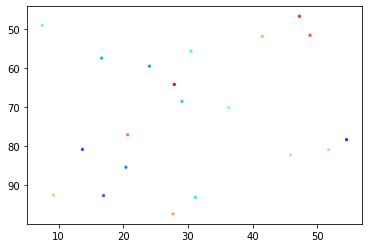

[[ 9.45199457e+02  6.95342658e+00  3.28290474e+02  4.25000000e+05]
 [ 4.26942916e+01  9.91052992e+02 -1.38019038e+02  8.83000000e+04]
 [-2.89629478e-01  1.98669331e-01  9.36293364e-01  1.00000000e+03]]


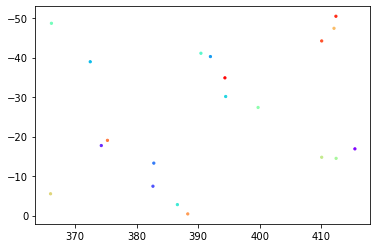

[[ 6.94175963e-06 -3.45698578e-06  9.60055894e-03]
 [ 1.90158951e-05 -5.00472712e-06  2.43002991e-02]
 [-1.14412825e-02 -3.18813006e-02  1.00000000e+00]]
-9.992007221626409e-16
-6.217248937900877e-15
-3.635980405647388e-15
-4.218847493575595e-15
-5.329070518200751e-15
-7.327471962526033e-15
-3.552713678800501e-15
-1.4432899320127035e-15
-3.3306690738754696e-15
-1.021405182655144e-14
-2.4424906541753444e-15
5.551115123125783e-16
-6.106226635438361e-16
-6.827871601444713e-15
-1.7763568394002505e-15
-1.3895135042574225e-15
-6.217248937900877e-15
2.220446049250313e-16
2.220446049250313e-16
-3.9968028886505635e-15
[[  6.94175963  -3.45698578   9.65234922]
 [ 19.01589507  -5.00472712  24.68909397]
 [-10.14674192 -32.27905653   0.53965831]]


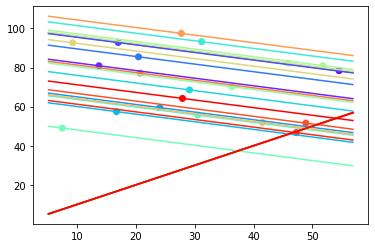

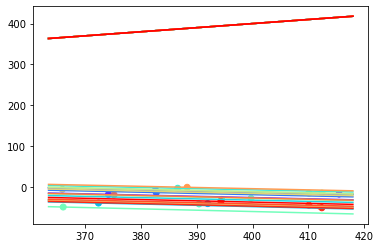

In [28]:
Kl = [ [1000 , 0 , 35 ] , [0 , 1000 , 55.3 ] , [0 , 0 , 1 ] ]
Kl = np.array(Kl , dtype = np.float)
p1 = -0.3
Hl = [ [ np.cos(p1) , 0 , np.sin(p1) , 280] , [0 , 1 , 0 , 33] , [-np.sin(p1) , 0 , np.cos(p1) , 1000] , [0 , 0 , 0 , 1] ]
Hl = np.array(Hl , dtype = np.float)
P1 = Pmatrix( Mmatrix(Kl) , Hl)

pix_pts1 = np.zeros((3, 20))
for i in range(pts.shape[1]):
    pix_pts1[: , i] = P1 @ pts[: , i]
    pix_pts1[: , i] = pix_pts1[: , i] / pix_pts1[ 2 , i]
fig = plt.figure()
plt.scatter(pix_pts1[0], pix_pts1[1], s=5 , c=colors)
plt.gca().invert_yaxis()
plt.show()

Kr = [ [1000 , 0 , 35 ] , [0 , 1000 , 55.3 ] , [0 , 0 , 1 ] ]
Kr = np.array(Kr , dtype = np.float)
p2 = 0.3
Hr = [ [ np.cos(p2) , 0 , np.sin(p2) , 390] , [0 , 1 , 0 , 33] , [-np.sin(p2) , 0 , np.cos(p2) , 1000] , [0 , 0 , 0 , 1] ]
Hr = np.array(Hr , dtype = np.float)
Hr[0:3 , 0:3] = rotatex(0.2) @ rotatey(0.3)
P2 = Pmatrix( Mmatrix(Kr) , Hr)
print(P2)
pix_pts2 = np.zeros((3, 20))
for i in range(pts.shape[1]):
    pix_pts2[: , i] = P2 @ pts[: , i]
    pix_pts2[: , i] = pix_pts2[: , i] / pix_pts2[ 2 , i]
fig = plt.figure()
plt.scatter(pix_pts2[0], pix_pts2[1], s=5 , c=colors)
plt.gca().invert_yaxis()
plt.show()

A = np.zeros((npoints, 9))
for i in range(npoints):
    pl = pix_pts1[: , i]
    pr = pix_pts2[: , i]
    pl = pl.reshape(3,1)
    pr = pr.reshape(1,3)
    base = np.zeros((9,1),dtype = np.float)
    
    base[0:3] = pl * pr[0,0]
    base[3:6] = pl * pr[0,1]
    base[6:9] = pl * pr[0,2]
    
    base = base.reshape(1,9)
    A[i] = base

u, s, vh = np.linalg.svd(A, full_matrices=True)
t = vh[-1, :] / vh[-1, -1]
F = t.reshape(3, 3)
F = F.T
print(F)
for i in range (npoints):
    print(pix_pts1[:, i] @ F @ pix_pts2[:, i])

E = Kl.T @ F @ Kr
print(E)

plt.scatter(pix_pts1[0,:], pix_pts1[1,:], c=colors)
s,e = plt.gca().get_xlim()

u = np.linspace(s,e,100)

for i in range(len(pix_pts2.T)):
    coef = findEpipolar(F, pix_r=pix_pts2[:,i])
    v = []
    for j in range(100):
        v.append(findOther(coef, u=u[j]))
    plt.plot(u,np.array(v),c=colors[i])

plt.show()

plt.scatter(pix_pts2[0,:], pix_pts2[1,:], c=colors)
s,e = plt.gca().get_xlim()
u = np.linspace(s,e,100)

for i in range( len(pix_pts1.T)):
    coef = findEpipolar(F, pix_l=pix_pts1[:,i])
    v = []
    for j in range(100):
        v.append(findOther(coef, u=u[j]))
    plt.plot(u,np.array(v),c=colors[i])

plt.show()